## Defining Models + Visualization

In [67]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

class Chain_1D():
    def __init__(self, N:int, r:float, u:float, h:float):
        self.N = N
        self.theta = np.array([np.pi*2*random.random() for i in range(N)])
        self.J_L = np.add(np.random.choice([-1.0, 1.0], size=(N), p=(0.5-u/2, 0.5+u/2)), h*np.ones((N)))
        self.J_R = np.add(np.random.choice([-1.0, 1.0], size=(N), p=(0.5-u/2, 0.5+u/2)), h*np.ones((N)))
    
    def evolve_timestep(self, dt: float):
        theta_dot = np.array([(self.J_R[i]*np.sin(self.theta[(i+1)%self.N] - self.theta[i]) + self.J_L[(i-1)%self.N]*np.sin(self.theta[(i-1)%self.N] - self.theta[i])) for i in range(self.N)])
        self.theta = np.add(self.theta, dt*theta_dot)

    def evolve_and_record(self, t:float, dt:float):
        n_T = int(t//dt)
        theta_history =[]
        for timestep in range(n_T):
            if timestep%int(1/dt) == 0:
                theta_history.append(self.theta%(np.pi))
            self.evolve_timestep(dt)
        return np.array(theta_history)
    
    def evolve_and_record_all(self, t:float, dt:float):
        n_T = int(t//dt)
        theta_history =[]
        for timestep in range(n_T):
            theta_history.append(self.theta%(np.pi))
            self.evolve_timestep(dt)
        return np.array(theta_history)
    

class Chain_2D(Chain_1D):
    def __init__(self, N: int, r: float, kappa: float):
        self.N = N
        self.theta = np.array([[np.pi*2*random.random() for i in range(N)] for j in range(N)])
        J_tilde_R = np.array([np.random.choice([-1.0, 1.0], size=(N), p=(0.5, 0.5)) for j in range(N)])
        J_tilde_L = np.array([[np.random.choice([J_tilde_R[j][i], -J_tilde_R[i][j]], p=(0.5+r/2, 0.5-r/2)) for i in range(N)] for j in range(N)])
        J_tilde_U = np.array([np.random.choice([-1.0, 1.0], size=(N), p=(0.5, 0.5)) for j in range(N)])
        J_tilde_D = np.array([[np.random.choice([J_tilde_U[j][i], -J_tilde_U[i][j]], p=(0.5+r/2, 0.5-r/2)) for i in range(N)] for j in range(N)])

        self.couplings_R = np.add(kappa*np.copy(J_tilde_R), (1-kappa)*np.ones((N,N)))
        self.couplings_L = np.add(kappa*np.copy(J_tilde_L), (1-kappa)*np.ones((N,N)))
        self.couplings_U = np.add(kappa*np.copy(J_tilde_U), (1-kappa)*np.ones((N,N)))
        self.couplings_D = np.add(kappa*np.copy(J_tilde_D), (1-kappa)*np.ones((N,N)))
        self.r = r
        self.kappa = kappa
        

    def evolve_timestep(self, dt: float):
        for i in range(self.N):
            for j in range(self.N):
                theta_dot_ij = (self.couplings_L[(i-1)%self.N][j]*np.sin(self.theta[(i-1)%self.N][j] - self.theta[i][j])
                + self.couplings_R[i][j]*np.sin(self.theta[(i+1)%self.N][j] - self.theta[i][j])
                + self.couplings_U[i][(j-1)%self.N]*np.sin(self.theta[i][(j-1)%self.N] - self.theta[i][j])
                + self.couplings_D[i][j]*np.sin(self.theta[i][(j+1)%self.N] - self.theta[i][j]))
                self.theta[i][j] = np.add(self.theta[i][j],dt*theta_dot_ij)
    

    def evolve_and_record(self, t: float, dt: float):
        self.__init__(self.N, self.r, self.kappa)
        n_T = int(t//dt)
        theta_history =[]
        for timestep in range(n_T):
            if timestep%int(1/dt) == 0:
                theta_history.append(self.theta%(np.pi))
            self.evolve_timestep(dt)
        return np.array(theta_history)
    

Let's create a tool to visualize slices of 1D and 2D:

In [21]:
def slice_viz(history, extra_info: None):
    fig, ax = plt.subplots(1,1)
    fig.set_figheight(4)
    fig.set_figwidth(4.5)
    ax.set_xlabel('Spin site $x$')
    ax.set_ylabel('Spin site $y$')
    ax.set_title('Angles mod($\pi$) \n '+extra_info)
    col = ax.pcolor(history, cmap='twilight', vmin=0, vmax=np.pi)
    plt.colorbar(mappable=col)
    plt.show()


In [36]:
from matplotlib.animation import FuncAnimation

T=100
dt=0.1
r=0.0
kappa=0.0
N=100
chain = Chain_2D(N=N, r=r, kappa=kappa)
histories = chain.evolve_and_record(t=T, dt=dt)


fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    ax.imshow(histories[frame,:,:], cmap='twilight')  # Display 2D slice at frame index
    ax.set_title(f"$\kappa=${str(kappa)} \n t={frame}")
    ax.axis('off')
    return ax
ani = FuncAnimation(fig, update, frames=T, interval=10)
ani.save(f'anims_2D/2d_r={str(r)}_k={str(kappa)}.gif', fps=200, writer='pillow')
plt.close()

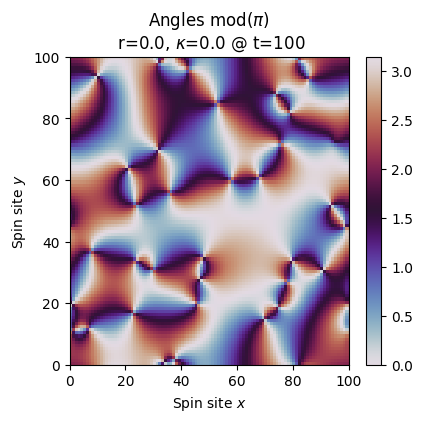

In [37]:
slice_viz(histories[99], f'r={r}, $\kappa$={kappa} @ t=100')

# Phase Diagram

In [295]:
import scipy
def wiener_entropy(history):
    N = len(history[0,0,:])
    #print(N)
    flatness=[]
    for i,j in zip(range(N), range(N)):
        #power_spectrum = np.square(np.absolute(np.fft.rfft(np.subtract(history[:,i], np.pi/2))))
        power_spectrum = np.square(np.absolute(np.fft.fft(np.exp(2*1j*history[:,i,j]))))
        gmean = scipy.stats.mstats.gmean(power_spectrum)
        mean = np.mean(power_spectrum)
        spectral_flatness = (gmean/mean)
        flatness.append(spectral_flatness)
    return np.mean(flatness)

In [296]:
def eval_phase_wiener(r, kappa, T=150, N=20):
    dt=0.1
    chain = Chain_2D(N, r=r, kappa=kappa)
    history_ordered = chain.evolve_and_record(t=T, dt=dt)
    return 1-wiener_entropy(history_ordered)

In [ ]:
rs = []
kappas = []
phases=[]
phase = []
r_pix = 21
kappa_pix= 31
for r in np.linspace(-1.0, 1.0, r_pix):
    p=[]
    for kappa in np.linspace(0.0, 1.0, kappa_pix):
        n = np.mean([eval_phase_wiener(r=r, kappa=kappa, N=20, T=100) for count in range(1)])
        phases.append(n)
        p.append(n)
        rs.append(r)
        kappas.append(kappa)
    print(f'searched r={round(r,2)}')
    phase.append(p)


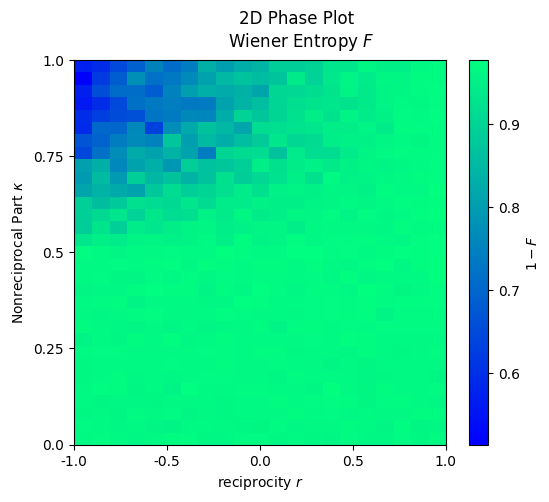

In [45]:
plt.figure(figsize=(6,5))
plt.imshow(np.flip(np.transpose(phase), 0), cmap='winter', interpolation='none', aspect='auto')
plt.xticks(np.linspace(-0.5, -0.5+r_pix, int(r_pix/4)), labels=np.round(np.linspace(-1.0, 1.0, int(r_pix/4)), 3))
plt.yticks(np.linspace(-0.5, -0.5+kappa_pix, int(kappa_pix/6)), labels=np.round(np.linspace(1.0, 0.0, int(kappa_pix/6)), 3))
plt.xlabel('reciprocity $r$')
plt.ylabel(r'Nonreciprocal Part $\kappa$')
plt.suptitle('2D Phase Plot \n Wiener Entropy $F$')
plt.colorbar(label=r'$1-F$')

In [297]:
def calc_kuramoto(frame:list, windowsize:int):
    size = frame.shape
    Ms = np.zeros(shape=frame.shape)
    for x in range(len(frame[:,0])):
        for y in range(len(frame[0,:])):
            Ms[x,y] = np.abs(np.sum(np.array([[np.exp(2*1.0j*frame[(x+i-int((windowsize)/2))%(frame.shape[0]), (y+j-int((windowsize)/2))%(frame.shape[1])]) for i in range(int((windowsize)))] for j in range(int((windowsize)))])))
    return np.mean(np.array(Ms))

In [298]:
def power_law(x, n):
    return x**n

In [299]:
def eval_phase_kuramoto(r, kappa, T=100, N=20):
    dt=0.1
    chain = Chain_2D(N, r=r, kappa=kappa)
    history_ordered = chain.evolve_and_record(T, dt)
    ydata = [calc_kuramoto(history_ordered[-1], i) for i in range(15)]
    xdata = np.square(np.arange(15))
    try:
        popt, pcov = scipy.optimize.curve_fit(power_law, xdata, ydata)
        #plt.plot(xdata, ydata)
        #plt.plot(xdata, [power_law(x, *popt) for x in xdata])
        #print(rf'r={r}, $\alpha$={alpha}, gives n={round(popt[0], 3)}')
        return popt[0]
    except:
        return 5

In [ ]:
rs = []
kappas = []
phases=[]
phase = []
r_pix = 16
kappa_pix= 31
for r in np.linspace(-1.0, 1.0, r_pix):
    p=[]
    for kappa in np.linspace(0.0, 1.0, kappa_pix):
        n = np.mean([eval_phase_kuramoto(r=r, kappa=kappa, N=20, T=100) for count in range(3)])
        phases.append(n)
        p.append(n)
        rs.append(r)
        kappas.append(kappa)
    print(f'searched r={round(r,2)}')
    phase.append(p)


In [ ]:
plt.figure(figsize=(6,5))
plt.imshow(np.flip(np.transpose(phase), 0), cmap='winter', interpolation='none', aspect='auto')
plt.xticks(np.linspace(-0.5, -0.5+r_pix, int(r_pix/4)), labels=np.round(np.linspace(-1.0, 1.0, int(r_pix/4)), 3))
plt.yticks(np.linspace(-0.5, -0.5+kappa_pix, int(kappa_pix/6)), labels=np.round(np.linspace(1.0, 0.0, int(kappa_pix/6)), 3))
plt.xlabel('reciprocity $r$')
plt.ylabel(r'Nonreciprocal Part $\kappa$')
plt.suptitle('2D Phase Plot')
plt.colorbar(label=r'$n$')

# Self-Generated Noise

In [254]:
import scipy
T=300
N=30
dt=0.1
r=0.9
kappa=0.85
chain = Chain_2D(N, r=r, kappa=kappa)
history = chain.evolve_and_record_all(t=T, dt=dt)



In [221]:
def f(x,a,b,c):
    x=np.array(x)
    #return a*np.e**(b*(x))+ c + a*np.e**(b*(10*T+(-1)*x))
    return a*(x**b) + a*((10*T-1*x)**b) +0.01

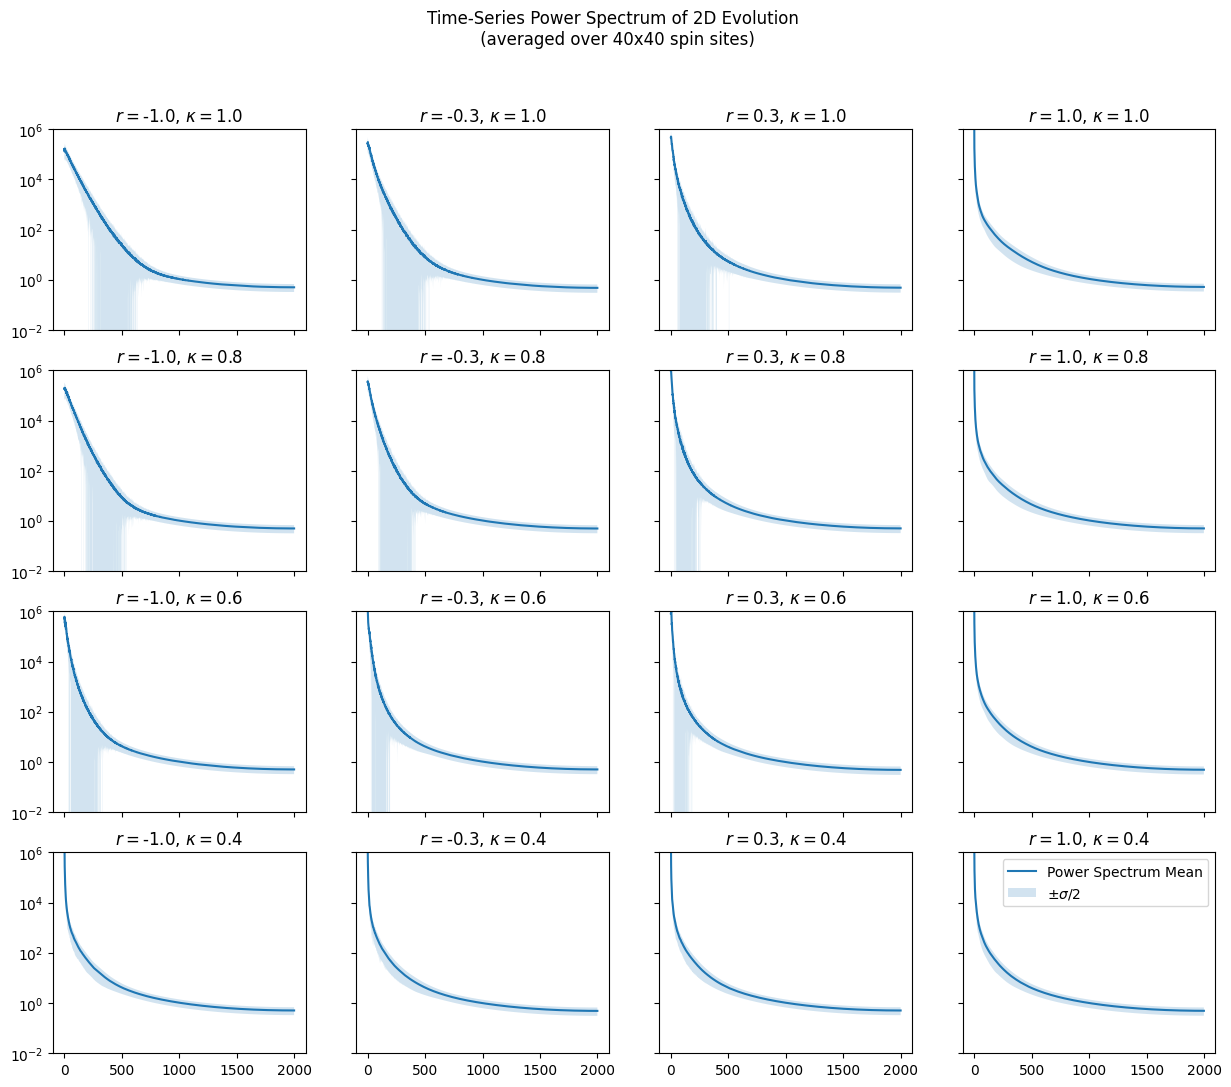

In [281]:
rs = [-1.0, -0.3, 0.3, 1.0]
kappas = [1.0, 0.8, 0.6, 0.4]

T=400
N=40
fix, axs = plt.subplots(len(kappas),len(rs), sharex=True, sharey=True, figsize=(15,12))
x=-1
for r in rs:
    print(r)
    x+=1
    y=-1
    for kappa in kappas:
        y+=1
        
        chain = Chain_2D(N, r=r, kappa=kappa)
        history = chain.evolve_and_record_all(t=T, dt=dt)
        power_spectra = []
        for i in range(N):
            for j in range(N):
                #power_spectrum = np.square(np.absolute(np.fft.rfft(np.subtract(history[:,i], np.pi/2))))
                power_spectrum = np.square(np.absolute(np.fft.fft(np.exp(2*1j*history[:,i,j]))))[:int(10*T/2)]
                power_spectra.append(power_spectrum)
        axs[y,x].plot(range(int(10*T/2)), np.mean(power_spectra, axis=0), label='Power Spectrum Mean')
        axs[y,x].fill_between(range(int(10*T/2)), np.mean(power_spectra, axis=0)-0.5*np.std(power_spectra, axis=0), np.mean(power_spectra, axis=0)+0.5*np.std(power_spectra, axis=0), alpha=0.2, label='$\pm \sigma/2$')
        axs[y,x].set_yscale('log')
        #axs[y,x].set_xscale('log')
        axs[y,x].set_ylim(top=10**6, bottom=0.01)

        axs[y,x].set_title(f'$r=${r}, $\kappa=${kappa}')
        #axs[y,x].set_ylabel('Power (|FT|^2)')
        #axs[y,x].set_xlabel('frequency')
        #plt.xlim(left=3, right=500)

#popt, pcov = scipy.optimize.curve_fit(f, range(int(10*T/2))[10:], np.mean(power_spectra, axis=0)[10:], p0=[10**5, -0.01, 0.1])#p0=[10**5, -0.01, 0.1], bounds=([0,-np.inf,0], [np.inf, np.inf, np.inf]))
#print(popt)

#plt.plot(range(int(10*T/2))[10:], f(range(int(10*T/2)), *popt)[10:], label = f'Exp + const fit')
plt.suptitle(f'Time-Series Power Spectrum of 2D Evolution \n (averaged over {N}x{N} spin sites)')
plt.legend()
plt.show()

# Temporal Correlations

In [38]:
def calc_Ct(history, t, t_w):
    row1 = np.array(history)[t_w, :, :].flatten()
    row2 = np.array(history)[t_w+t, :, :].flatten()
    return np.mean(np.exp(2*1j*np.subtract(row2, row1)))

In [75]:
T=200
dt=0.1
r=0.0
kappa=0.6
N=100
chain = Chain_2D(N=N, r=r, kappa=kappa)
histories = np.array([chain.evolve_and_record(t=T, dt=dt) for i in range(2)])


In [79]:
histories.shape

(2, 200, 100, 100)

In [80]:
t_ws = [1, 5, 10, 50, 100]
t_w_correlations =[]
for t_w in t_ws:
    t_w_correlations.append([np.abs(np.mean([calc_Ct(histories[run, :, :, :], t, t_w) for run in range(histories.shape[0])])) for t in range(200-t_w)])

In [118]:
t_w_correlations=np.load('2d_temporal_corrs.npy')

Text(0, 0.5, '$C_t(t_W, t_W+t)$')

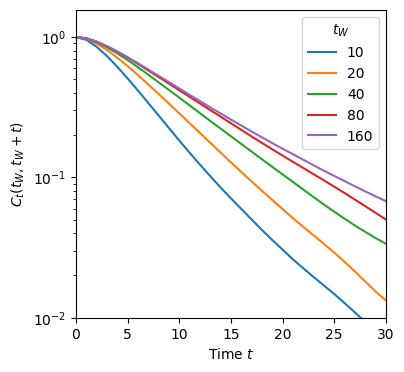

In [132]:
t_ws = [10, 20, 40, 80, 160]
plt.figure(figsize=(4,4))
for i in range(len(t_ws)):
    plt.plot(t_w_correlations[i], label=str(t_ws[i]))
plt.yscale('log')
plt.ylim(bottom=0.01)
plt.legend(title='$t_W$')
plt.xlim(left=0, right=30)
plt.xlabel('Time $t$')
plt.ylabel('$C_t(t_W, t_W+t)$')

# Spatial Correlations

In [101]:
def calc_Cx(history, x, t):
    return np.mean([[np.exp(2*1j*np.subtract(history[t, i, j], history[t,i,(j+x)%history.shape[2]])) for i in range(history.shape[2])]for j in range(history.shape[2])])

In [125]:
T=161
dt=0.1
r=0.4
kappa=0.0
N=100
runs = 200
chain = Chain_2D(N=N, r=r, kappa=kappa)
histories = [chain.evolve_and_record(t=T, dt=dt) for i in range(runs)]

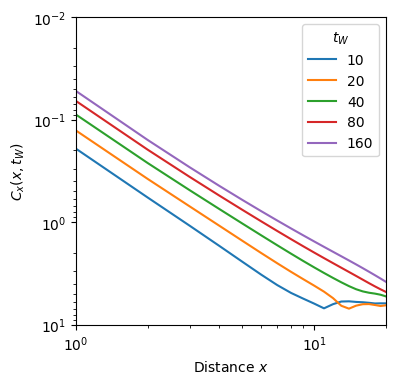

In [129]:
t_ws = [10, 20, 40, 80, 160]
plt.figure(figsize=(4,4))
for i in range(len(t_ws)):
    plt.plot([-np.log(np.abs(np.mean([calc_Cx(histories[j], x, t_ws[i]) for j in range(runs)]))) for x in range(50)], label=str(t_ws[i]))
plt.yscale('log')
plt.xscale('log')
plt.ylim(bottom=0.01)
plt.legend(title='$t_W$')
plt.xlim(left=1, right=20)
plt.xlabel('Distance $x$')
plt.ylabel('$C_x(x, t_W)$')
plt.gca().invert_yaxis()